In [362]:
import numpy as np
np.random.seed(2020)
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scikitplot.estimators import plot_learning_curve

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train size: {0}, test size: {1}'.format(train.shape, test.shape))

Train size: (891, 12), test size: (418, 11)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Get labels
labels = train.pop('Survived')

# Get indecies
n_train = train.shape[0]

# Get PassangerID
train_id = train.pop('PassengerId')
test_id = test.pop('PassengerId')

# Unite train and test data 
raw_data = pd.concat([train, test])
raw_data.reset_index(inplace=True, drop=True)

In [8]:
# Lack of data
pd.DataFrame({'Percent': ((raw_data.isnull().sum() / len(raw_data))*100), 
              'Records': raw_data.isnull().sum()}).sort_values(by='Percent', ascending=False)

,Percent,Records
Cabin,77.463713,1014
Age,20.091673,263
Embarked,0.152788,2
Fare,0.076394,1
Pclass,0.000000,0
Name,0.000000,0
Sex,0.000000,0
SibSp,0.000000,0
Parch,0.000000,0
Ticket,0.000000,0


## Clean data

In [9]:
cleaned_data = raw_data.copy()

In [10]:
# Drop column with the most of empty values
cleaned_data.drop(['Cabin'], axis=1, inplace=True)

Column "Name" includes title ('Mr', 'Miss' etc.), I suppose title has strong correlation with age. I'm going to fill empty values for age using this information.

In [11]:
cleaned_data['Name'].sample(10)

406                      Widegren, Mr. Carl/Charles Peter
595                           Van Impe, Mr. Jean Baptiste
687                                     Dakic, Mr. Branko
619                                   Gavey, Mr. Lawrence
44                          Devaney, Miss. Margaret Delia
1206                                 Hagardon, Miss. Kate
1234    Cardeza, Mrs. James Warburton Martinez (Charlo...
1213                                   Nesson, Mr. Israel
632                             Stahelin-Maeglin, Dr. Max
525                                    Farrell, Mr. James
Name: Name, dtype: object

In [12]:
# Get title from name column
cleaned_data['Title'] = cleaned_data['Name'].map(lambda x: x.split(',')[1].split(' ')[1])
cleaned_data['Title'].value_counts()

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Rev.           8
Dr.            8
Col.           4
Ms.            2
Mlle.          2
Major.         2
Don.           1
Dona.          1
the            1
Capt.          1
Sir.           1
Lady.          1
Jonkheer.      1
Mme.           1
Name: Title, dtype: int64

In [13]:
# Map titles for more neat view
titles = {'Mr.': 'Mr',
         'Miss.': 'Miss',
         'Mrs.': 'Mrs',
         'Master.': 'Master',
         'Dr.': 'Dr',
         'Rev.': 'Rev'}

cleaned_data['Title'] = cleaned_data['Title'].map(lambda x: titles.get(x, 'Other'))

cleaned_data['Title'].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Other      18
Dr          8
Rev         8
Name: Title, dtype: int64

In [14]:
# Fill age with values depending on the median for title
ages = dict(cleaned_data.groupby('Title')['Age'].median())

cleaned_data['Age'] = cleaned_data['Age'].fillna(cleaned_data['Title'].map(ages))

In [15]:
# Fill rest empty values
cleaned_data['Fare'].fillna(0, inplace=True)
cleaned_data['Embarked'].fillna('None', inplace=True)

In [16]:
pd.DataFrame({'Percent': ((cleaned_data.isnull().sum() / len(cleaned_data))*100), 
              'Records': cleaned_data.isnull().sum()}).sort_values(by='Percent', ascending=False)

,Percent,Records
Pclass,0.0,0
Name,0.0,0
Sex,0.0,0
Age,0.0,0
SibSp,0.0,0
Parch,0.0,0
Ticket,0.0,0
Fare,0.0,0
Embarked,0.0,0
Title,0.0,0


## Transform categorical data to numerical

In [17]:
cleaned_data['Sex'] = cleaned_data['Sex'].map(lambda x: int(x == 'male'))

In [18]:
for feat in ['Title', 'Embarked']: 
    dummies = pd.get_dummies(cleaned_data[feat], prefix='{0}_'.format(feat), drop_first=True)
    cleaned_data = pd.concat([cleaned_data, dummies], axis=1)

In [19]:
cleaned_data.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Title__Other,Title__Rev,Embarked__None,Embarked__Q,Embarked__S
0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,Mr,0,0,1,0,0,0,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,Mrs,0,0,0,1,0,0,0,0,0
2,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,0,0,0,0,0,0,1


In [485]:
# Separate data set on train and test part
train_data = cleaned_data.iloc[:n_train, :]
test_data = cleaned_data.iloc[n_train:, :]

## Machine learning

In [513]:
def get_x(data=train_data, normalize_list=normalize_list):
    """
    Return X, where normalised features from normalise list united with rest numerical columns.
    Return scaled X, where all feature are normalised.
    """
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data.loc[:, normalize_list])
    
    one_hot_list = []
    for column in data.select_dtypes(include=np.number).columns:
        if column not in normalize_list:
            one_hot_list.append(column)
       
    x = np.concatenate([scaled, data.loc[:, one_hot_list].values], axis=1)
    
    x_scaled = scaler.fit_transform(data[data.select_dtypes(include=np.number).columns])
    
    return x, x_scaled

In [514]:
def check_models(data=df, normalize_list=normalize_list, models_list=models):
    """Train model with cross validation and print result for few models with X and X_scaled"""
     
    X, X_scaled = get_x(data, normalize_list)
    y = labels
    
    models = models_list
    
    results = {}
    for name, model in models.items():
        score = cross_val_score(model, X, y, cv=10, scoring='accuracy')
        results[name] = np.mean(score)
        
    scaled_result = {}    
    for name, model in models.items():
        score = cross_val_score(model, X_scaled, y, cv=10, scoring='accuracy')
        scaled_result[name] = np.mean(score)


    results = pd.DataFrame({'Model': [key for key in results.keys()], 
                            'Accuracy': [value for value in results.values()], 
                            'Accuaracy_scaled': [value for value in scaled_result.values()]})
        
    return results.sort_values(by='Accuracy', ascending=False) 

In [500]:
# Features for scale
normalize_list = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# Try few models
models = {'LogisticRegression': LogisticRegression(solver="liblinear"),
         'DecisionTree': DecisionTreeClassifier(),
         'RandomForest': RandomForestClassifier(),
         'ExtraTreesClassifier': ExtraTreesClassifier(),
         'SupportVectorMachine': SVC(),
         'KNeighbours': KNeighborsClassifier(), 
         'XGBoost': XGBClassifier()}


check_models(train_data, normalize_list, models)

,Model,Accuracy,Accuaracy_scaled
4,SupportVectorMachine,0.835044,0.835044
6,XGBoost,0.832797,0.832797
0,LogisticRegression,0.826030,0.826030
2,RandomForest,0.811523,0.805905
5,KNeighbours,0.802522,0.802522
3,ExtraTreesClassifier,0.802497,0.800237
1,DecisionTree,0.767728,0.767740


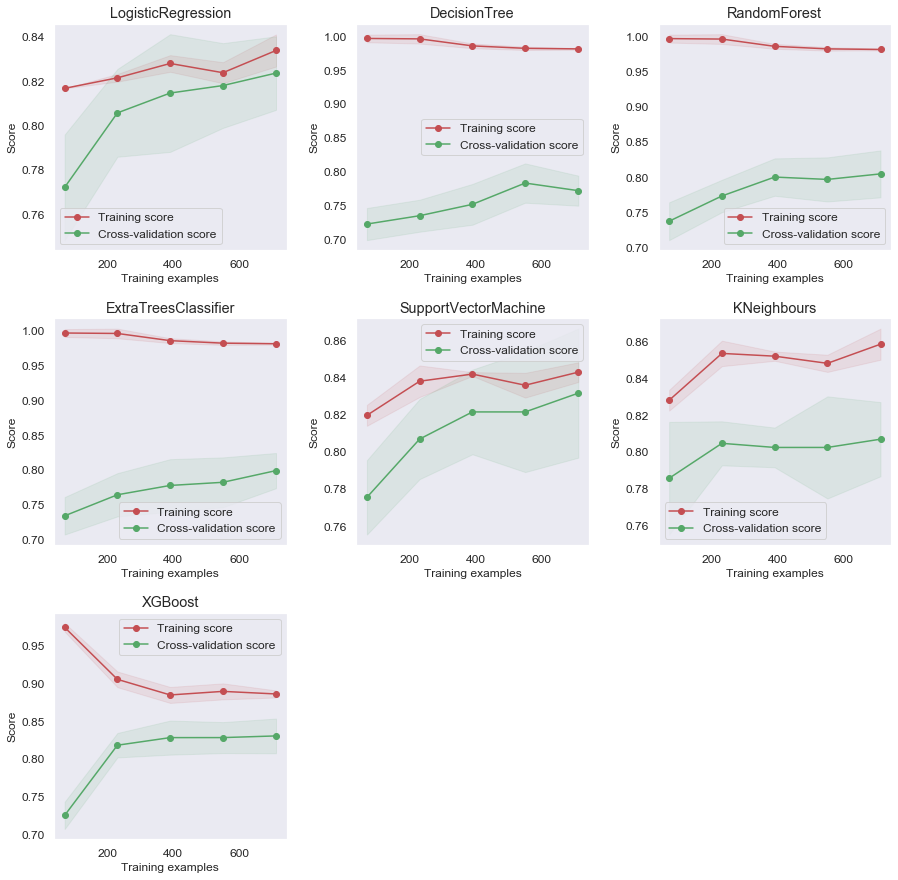

In [511]:
# Plot learning curve for all models
X, X_scaled = get_x(train_data, normalize_list)
y = labels

i = 1
fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for name, model in models.items():
    ax = fig.add_subplot(3, 3, i)
    plot_learning_curve(model, X, y, title=name, ax=ax)
    i += 1
   

### Feature engineering

In [520]:
# Copy for testing new features
df = train_data.copy()

normalize_list = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

models = {'LogisticRegression': LogisticRegression(solver="liblinear", random_state=46),
             'SupportVectorMachine': SVC(random_state=46),
             'XGBoost': XGBClassifier(random_state=46)}

check_models(df, normalize_list, models)

,Model,Accuracy,Accuaracy_scaled
1,SupportVectorMachine,0.835044,0.835044
2,XGBoost,0.832797,0.832797
0,LogisticRegression,0.826030,0.826030


In [521]:
df['Family_size'] = df['Parch'] + df['SibSp']
normalize_list.append('Family_size')

check_models(df, normalize_list, models)

,Model,Accuracy,Accuaracy_scaled
1,SupportVectorMachine,0.835044,0.835044
2,XGBoost,0.835044,0.835044
0,LogisticRegression,0.828277,0.828277


In [522]:
df['old_woman'] = ((df['Sex'] == 0) & (df['Age'] > 50)).astype('int')

check_models(df, normalize_list, models)

,Model,Accuracy,Accuaracy_scaled
2,XGBoost,0.837303,0.837303
1,SupportVectorMachine,0.833920,0.833920
0,LogisticRegression,0.829401,0.829401


In [523]:
df['rich_woman'] = ((df['Sex'] == 0) & (df['Fare'] > 30)).astype('int')

check_models(df, normalize_list, models)

,Model,Accuracy,Accuaracy_scaled
2,XGBoost,0.83392,0.83392
1,SupportVectorMachine,0.83392,0.83392
0,LogisticRegression,0.82603,0.82603


In [524]:
df['is_mother'] = ((df['Sex'] == 0) & (df['Parch'] > 0) & 
                           (df['SibSp'] > 0) & (df['Age'] > 18)).astype('int')

check_models(df, normalize_list, models)

,Model,Accuracy,Accuaracy_scaled
2,XGBoost,0.831698,0.831698
1,SupportVectorMachine,0.823808,0.823808
0,LogisticRegression,0.821536,0.821536


In [525]:
df['rich_man'] = ((df['Sex'] == 1) & (df['Fare'] > 30)).astype('int')

check_models(df, normalize_list, models)

,Model,Accuracy,Accuaracy_scaled
2,XGBoost,0.831698,0.831698
0,LogisticRegression,0.821536,0.821536
1,SupportVectorMachine,0.820449,0.820449


In [526]:
df['is_single'] = (df['Family_size'] == 0).astype('int')

check_models(df, normalize_list, models)

,Model,Accuracy,Accuaracy_scaled
2,XGBoost,0.831698,0.831698
1,SupportVectorMachine,0.827179,0.827179
0,LogisticRegression,0.822672,0.822672


In [527]:
df['big_family'] = (df['Family_size'] >= 5).astype('int')

check_models(df, normalize_list, models)

,Model,Accuracy,Accuaracy_scaled
2,XGBoost,0.831698,0.831698
1,SupportVectorMachine,0.826030,0.826030
0,LogisticRegression,0.820437,0.820437


In [528]:
df['young_man'] = ((df['Sex'] == 1) & (df['Age'] < 17)).astype('int')

check_models(df, normalize_list, models)

,Model,Accuracy,Accuaracy_scaled
2,XGBoost,0.831698,0.831698
1,SupportVectorMachine,0.826030,0.826030
0,LogisticRegression,0.821561,0.821561


In [530]:
def get_new_feats(data):

    data['Family_size'] = data['Parch'] + data['SibSp']

    return data
    

In [532]:
def add_new_feats(data):
    """Add new feats to dataset and return X and X_scaled"""
    
    df_with_feats = get_new_feats(data)
    x, x_scaled = get_x(df_with_feats)
    
    return x, x_scaled


# Get X and fit model
X_train, X_train_scaled = add_new_feats(train_data)

svc_model = SVC()
svc_model.fit(X_train_scaled, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Test part

In [534]:
# Get X for test part, make prediction and save in csv
X_test, X_test_scaled = add_new_feats(test_data)
y_pred = svc_model.predict(X_test_scaled)

predictions = pd.DataFrame({'PassengerId': test_id, 'Survived': y_pred})
predictions.to_csv('submission.csv', index=False)

Accuracy on Kaggle: 0.80382 